Selected Features: ['AMT', 'DOSE', 'ADDL', 'D25BASE', 'SEASON', 'Sunlight Exposure (Hours/Day)', 'Dietary Vitamin D Intake (IU/day)']
🔹 Final Random Forest Accuracy: 93.68%
🔹 XGBoost Accuracy: 99.79%
Optimized Random Forest RMSE: 18.0988, R-squared: 0.9368
XGBoost RMSE: 3.2859, R-squared: 0.9979


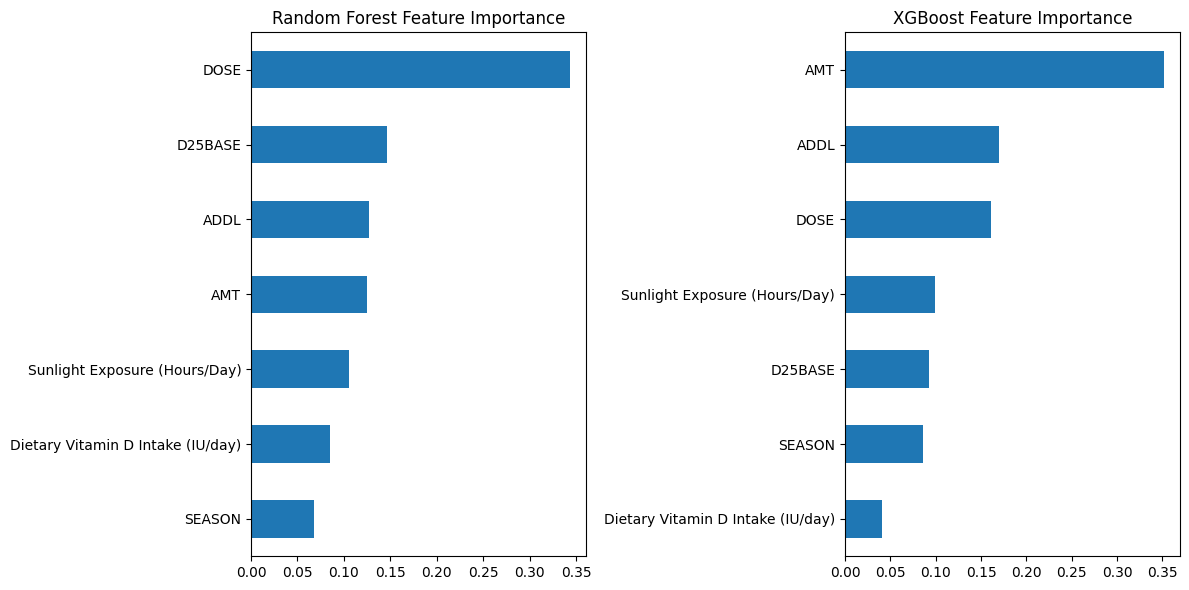

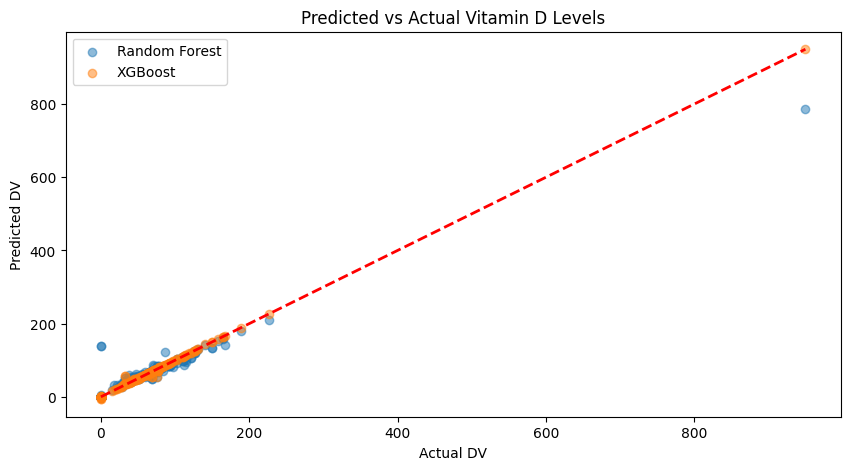

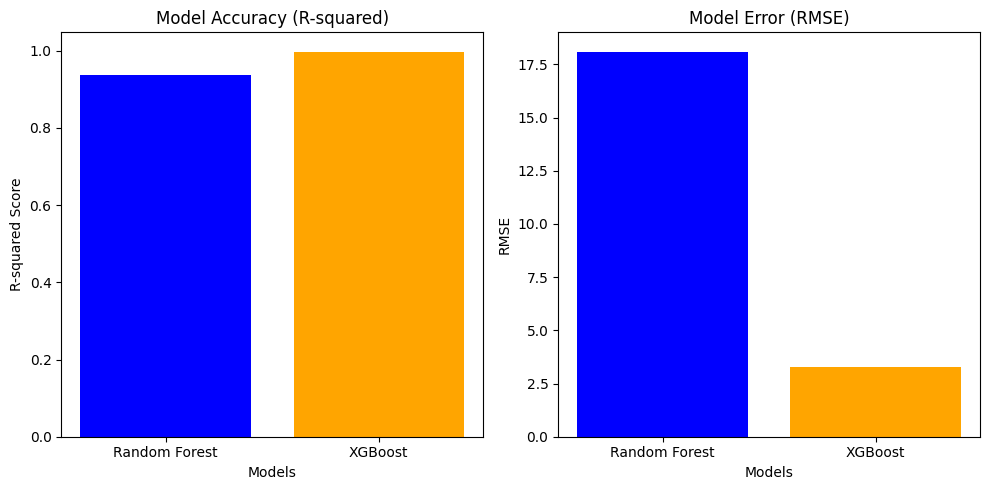

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

# Load dataset
df = pd.read_csv("/content/datasets.csv")  # Replace with your actual dataset path

# Drop rows with missing values
df.dropna(inplace=True)

# Convert categorical variables to strings to avoid encoding issues
df = df.astype(str)

# Encoding categorical variables
categorical_cols = ["SEX", "SEASON", "CONTINENTS", "Skin Type (Fitzpatrick Scale)"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with remaining NaN values after conversion
df.dropna(inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=["DV", "ID", "TIME"])
y = df["DV"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection using Random Forest
selector = SelectFromModel(RandomForestRegressor(n_estimators=500, random_state=42), threshold="median")
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Keep only selected feature names
selected_features = df.drop(columns=["DV", "ID", "TIME"]).columns[selector.get_support()]
print("Selected Features:", list(selected_features))

# Hyperparameter tuning for Random Forest
param_distributions = {
    'n_estimators': [500, 800, 1000, 1200],  # Increased range of n_estimators
    'max_depth': [10, 20, 30, None],  # Added more depth options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}

rf_model = RandomForestRegressor()

# Use optimized settings for faster execution
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions,
    n_iter=30,  # Increased n_iter to explore more hyperparameters
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    n_jobs=2,  # Parallel processing with two cores
    random_state=42
)

random_search_rf.fit(X_train_selected, y_train)

# Best Random Forest model
rf_best_model = random_search_rf.best_estimator_

# Bagging Regressor
bagging_rf = BaggingRegressor(estimator=rf_best_model, n_estimators=10, random_state=42)
bagging_rf.fit(X_train_selected, y_train)

# Predictions
y_pred_rf = bagging_rf.predict(X_test_selected)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# XGBoost Model (as a comparison)
xgb_model = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9, random_state=42)
xgb_model.fit(X_train_selected, y_train)
y_pred_xgb = xgb_model.predict(X_test_selected)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Accuracy Display
rf_accuracy = r2_rf * 100
xgb_accuracy = r2_xgb * 100

print(f"🔹 Final Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"🔹 XGBoost Accuracy: {xgb_accuracy:.2f}%")
print(f"Optimized Random Forest RMSE: {rmse_rf:.4f}, R-squared: {r2_rf:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}, R-squared: {r2_xgb:.4f}")

# Feature Importance
feature_importances_rf = pd.Series(rf_best_model.feature_importances_, index=selected_features)
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=selected_features)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_importances_rf.sort_values().plot(kind='barh', title='Random Forest Feature Importance')
plt.subplot(1, 2, 2)
feature_importances_xgb.sort_values().plot(kind='barh', title='XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel("Actual DV")
plt.ylabel("Predicted DV")
plt.title("Predicted vs Actual Vitamin D Levels")
plt.legend()
plt.show()

# Accuracy Comparison
models = ['Random Forest', 'XGBoost']
r2_scores = [r2_rf, r2_xgb]
rmse_scores = [rmse_rf, rmse_xgb]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color=['blue', 'orange'])
plt.xlabel("Models")
plt.ylabel("R-squared Score")
plt.title("Model Accuracy (R-squared)")

plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color=['blue', 'orange'])
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("Model Error (RMSE)")

plt.tight_layout()
plt.show()


# New Section